In [70]:
import kplr
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

from pandas import DataFrame
from exoparams import PlanetParams
import batman
optmin = optimize.minimize
plt.ion()
%matplotlib inline

** Kepler Data Load **

In [33]:
client = kplr.API()
koi3 = client.koi(3.01)

In [34]:
print(koi3.koi_period, koi3.koi_period_err1)

0.00466 -0.00466


In [35]:
lcs3short = koi3.get_light_curves(short_cadence=True)

** Allocate All Data for Kepler-3 **

**Huber etal 2017**

In [67]:
# From Hubert et al. 2017
kep3period = 4.88782433
kep3t0 = 2454957.812464 - keplaunch
kep3aoR = 14.64
kep3RpRs = 0.05856
kep3inc = 88.99
kep3ecc = 0.26493
kep3omeg = -162.149
kep3u1 = 0.646
kep3u2 = 0.048

In [73]:
# times, fluxs, ferrs = [], [], []
kep3_df_list = []
for lc in lcs3short:
    with lc.open() as f:
        if f[0].header['OBSMODE'] == 'short cadence':
            data     = f[1].data
            
            keepNow  = data["SAP_QUALITY"] == 0
            keepNow &= np.isfinite(data["TIME"])
            keepNow &= np.isfinite(data["PDCSAP_FLUX"])
            
            timesNow = np.ascontiguousarray(data["TIME"][keepNow], dtype=np.float64)
            fluxNow  = np.ascontiguousarray(data["PDCSAP_FLUX"][keepNow], dtype=np.float64)
            ferrNow  = np.ascontiguousarray(data["PDCSAP_FLUX_ERR"][keepNow], dtype=np.float64)
            
            phaseNow = ((timesNow - kep3t0) % kep3period)/kep3period
            phaseNow[phaseNow > .5] -= 1
            
            kep3_df           = DataFrame()
            kep3_df['time']  = timesNow
            kep3_df['flux']   = fluxNow
            kep3_df['ferr']   = ferrNow
            kep3_df['phase']  = phaseNow
            
            kep3_df_list.append(kep3_df)
#             times.append(timesNow)
#             fluxs.append(fluxNow)
#             ferrs.append(ferrNow)

In [ ]:
jdOffset = 2450000.0
kepStartEpoch = float(np.copy(h11t0)) + jdOffset

while kepStartEpoch > keplaunch:
    kepStartEpoch -= h11Per # start from way before kepler launched

kepStartEpoch -= jdOffset
# iTran = 200
sliceWidth = 0.5

kep3_slice_df_list = []

# %matplotlib inline
# plt.figure(figsize=(10,10))
# timeSlices, fluxSlices, ferrSlices, kep3Epochs = [],[],[],[]
for iEpoch in range(len(kep3_df_list)):#[2,9,29,33]:#
    # phases = (times[iEpoch] - h11t0) % h11Per / h11Per
    nEpochsNow = (np.diff(kep3_df_list[iEpoch]['phase']) < -0.9).sum()
    if nEpochsNow:
        while kepStartEpoch < kep3_df_list[iEpoch]['time'].min():
            kepStartEpoch += h11Per
        
        for iTran in range(nEpochsNow):
            kep3epochKt0 = kepStartEpoch + iTran * kep3period
            transitSliceK = (kep3_df_list[iEpoch]['time'] > kep3epochKt0 - sliceWidth) & \
            (times[iEpoch] < kep3epochKt0 + sliceWidth)
            if np.sum(transitSliceK):
                timeSliceK = times[iEpoch][transitSliceK]
                timeSlices.append(np.linspace(np.nanmin(timeSliceK), np.nanmax(timeSliceK), timeSliceK.size))
                fluxSlices.append(fluxs[iEpoch][transitSliceK])
                ferrSlices.append(ferrs[iEpoch][transitSliceK])
                kep3Epochs.append(kep3epochKt0)
            else:
                print(iEpoch, iTran)
               # plt.errorbar(times[iEpoch], fluxs[iEpoch], ferrs[iEpoch]

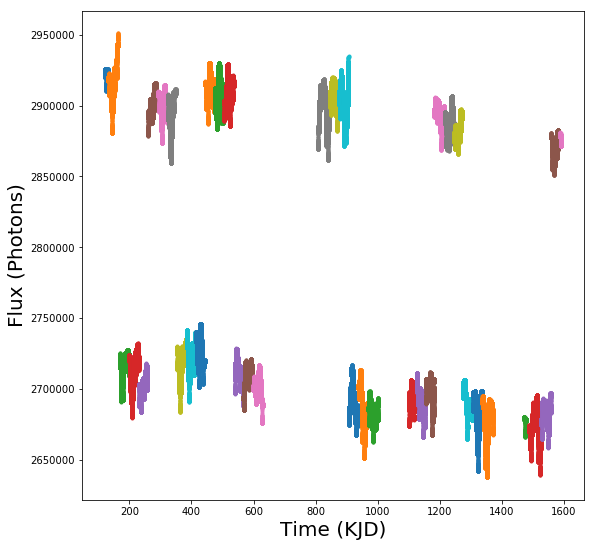

In [74]:
plt.figure(figsize=(9, 9))
for i in range(len(times)):
    plt.errorbar(kep3_df_list[i]['time'], kep3_df_list[i]['flux'], yerr = kep3_df_list[i]['ferr'], fmt = '.')

plt.xlabel("Time (KJD)", fontsize = 20)
plt.ylabel("Flux (Photons)", fontsize = 20)

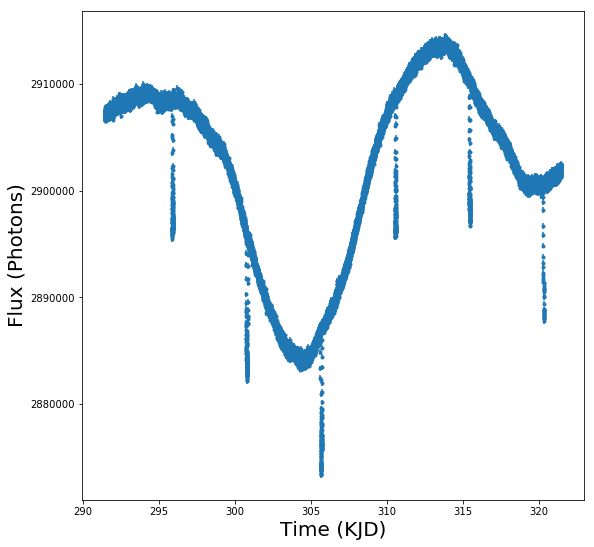

In [81]:
tmin, tmax  = 291,322
plt.figure(figsize=(9, 9))
for i in range(len(times)):
    timesi = kep3_df_list[i]['time']
    fluxsi = kep3_df_list[i]['flux']
    ferrsi = kep3_df_list[i]['ferr']
    useTime = (kep3_df_list[i]['time'] > tmin)&(kep3_df_list[i]['time'] < tmax)
    if sum(useTime):
        plt.errorbar(kep3_df_list[i]['time'][useTime], \
                     kep3_df_list[i]['flux'][useTime], \
                     kep3_df_list[i]['ferr'][useTime], fmt = '.')

# Limits are used to define a certain section of the graph
# plt.xlim(291,322)
# plt.ylim(3.975e5,4.06e5)
plt.xlabel("Time (KJD)", fontsize = 20);
plt.ylabel("Flux (Photons)", fontsize = 20);

** Old Planet Data Load **

** Phasing and Spliting Transits **

<Container object of 3 artists>

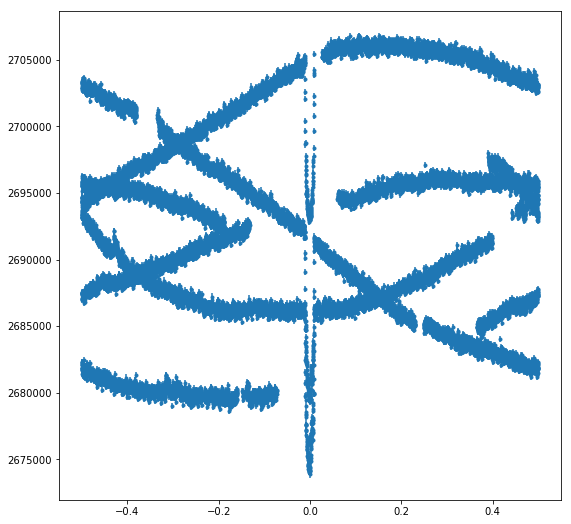

In [82]:
plt.figure(figsize=(9,9))
i = 23
plt.errorbar(kep3_df_list[i]['phase'], kep3_df_list[i]['flux'], kep3_df_list[i]['ferr'], fmt = '.');

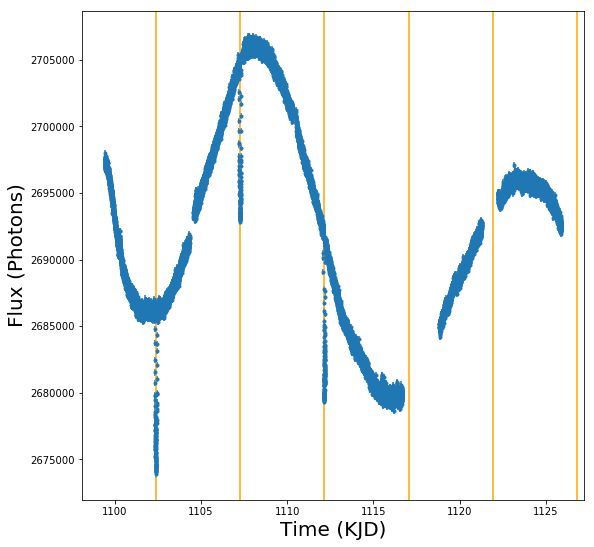

In [84]:
%matplotlib inline
plt.figure(figsize=(9,9))
i = 23
plt.errorbar(kep3_df_list[i]['time'], kep3_df_list[i]['flux'], yerr = kep3_df_list[i]['ferr'], fmt = '.')

for k in range(200, 206):
    plt.axvline(kep3t0 + k*kep3period, color='orange')
plt.xlabel("Time (KJD)", fontsize = 20);
plt.ylabel("Flux (Photons)", fontsize = 20);
# plt.xlim(218.8, 219.3)
# plt.ylim(360000, 362000)

**Slice One Segment Transit**

In [94]:
kTran = k-5
kep3epochKt0 = kep3t0 + kTran * kep3period

In [123]:
sliceWidth = 0.5
transitSlice = (kep3_df_list[i]['time'] > kep3epochKt0 - sliceWidth) * (kep3_df_list[i]['time'] < kep3epochKt0 + sliceWidth)
timeSliceK = kep3_df_list[i]['time'][transitSlice]
fluxSliceK = kep3_df_list[i]['flux'][transitSlice]
ferrSliceK = kep3_df_list[i]['ferr'][transitSlice]

timeSliceKmod = np.linspace(timeSliceK.min(), timeSliceK.max(), timeSliceK.size)

/Users/jonathan/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


<Container object of 3 artists>

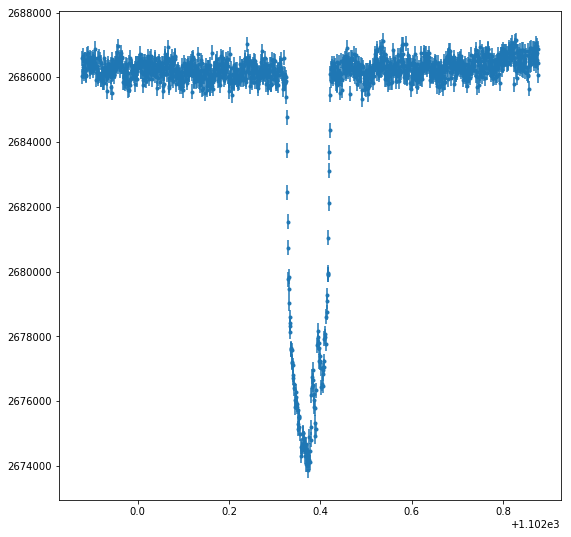

In [125]:
plt.figure(figsize=(9,9))
plt.errorbar(timeSliceK, fluxSliceK, yerr = ferrSliceK, fmt = '.')

**Outliers**

In [126]:
fluxdiff = np.diff(fluxSliceK)

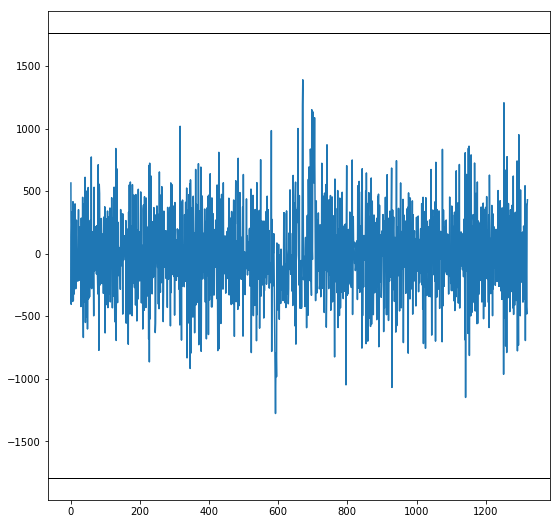

In [127]:
plt.figure(figsize = (9,9))
nsigma = 5
plt.plot(fluxdiff)
plt.axhline(np.nanmedian(fluxdiff) + nsigma * np.nanstd(fluxdiff), color = 'k', linestyle = '-', linewidth = 1)
plt.axhline(np.nanmedian(fluxdiff) - nsigma * np.nanstd(fluxdiff), color = 'k', linestyle = '-', linewidth = 1)

In [128]:
outliers = np.where(abs(fluxdiff - np.nanmedian(fluxdiff)) > nsigma * np.nanstd(fluxdiff))[0]
print('Initial Outliers:', outliers)

for o in outliers:
    beforeOutlier = list(fluxSlices[itran][o - 10+1: o + 1])
    afterOutlier  = list(fluxSlices[itran][o + 1+1: o + 11+1])
    fluxSliceK[o] = median(beforeOutlier + afterOutlier)

fluxdiff = np.diff(fluxSliceK)
outliers = np.where(abs(fluxdiff - np.nanmedian(fluxdiff)) > nsigma * np.nanstd(fluxdiff))[0]
print('Final Outliers:', outliers)

Initial Outliers: []
Final Outliers: []


In [129]:
plt.figure(figsize=(9,9));
# plt.errorbar(timeSliceK, fluxSliceK, yerr = ferrSliceK, fmt = '.')
for o in outliers[1::2]:
    plt.errorbar(timeSliceK[o], fluxSliceK[o], yerr = ferrSliceK[o], fmt = 'o', color='orange');

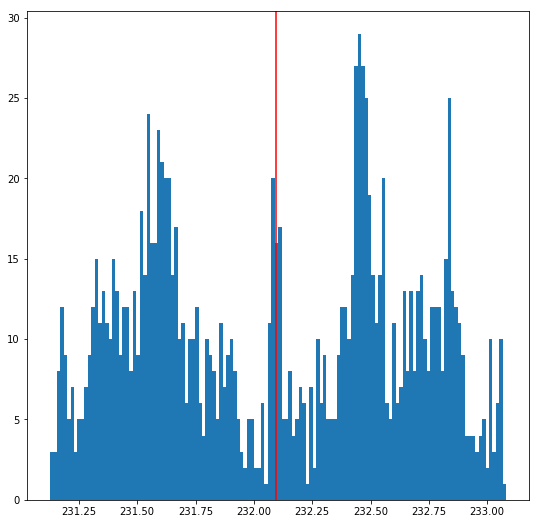

In [130]:
plt.figure(figsize = (9,9));
plt.hist(ferrSliceK[np.isfinite(ferrSliceK)],bins=ferrSliceK.size//10);
plt.axvline(np.nanmedian(ferrSliceK), color='red');

In [131]:
nanIndices  = np.where(np.isnan(fluxSliceK))[0]
medianDiff  = np.nanmedian(np.diff(fluxSliceK))

print('Initial NaNs:', nanIndices)

for n in nanIndices:
    beforeOutlier = list(fluxSlices[kTran][n - 10+1: n + 1])
    afterOutlier  = list(fluxSlices[kTran][n + 1+1 : n + 11+1])
    fluxSliceK[n] = median(beforeOutlier + afterOutlier)
    # fluxSliceK[n] = np.nanmedian(fluxSliceK)

print('Final NaNs:', np.where(np.isnan(fluxSliceK))[0])

Initial NaNs: []
Final NaNs: []


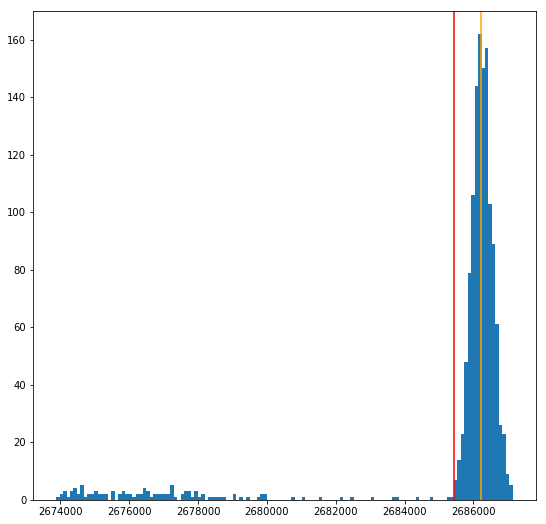

In [132]:
plt.figure(figsize = (9,9))
plt.hist(fluxSliceK, bins=fluxSliceK.size//10);
plt.axvline(np.mean(fluxSliceK), color='red')
plt.axvline(np.median(fluxSliceK), color='orange')

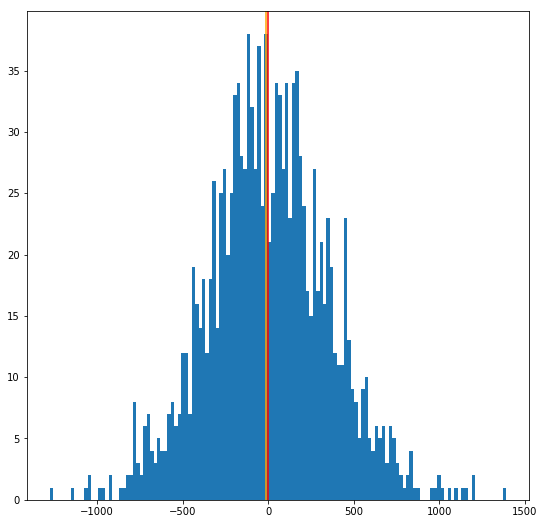

In [133]:
plt.figure(figsize = (9,9))
plt.hist(np.diff(fluxSliceK), bins=(fluxSliceK.size-1)//10);
plt.axvline(np.mean(np.diff(fluxSliceK)), color='red')
plt.axvline(np.median(np.diff(fluxSliceK)), color='orange')

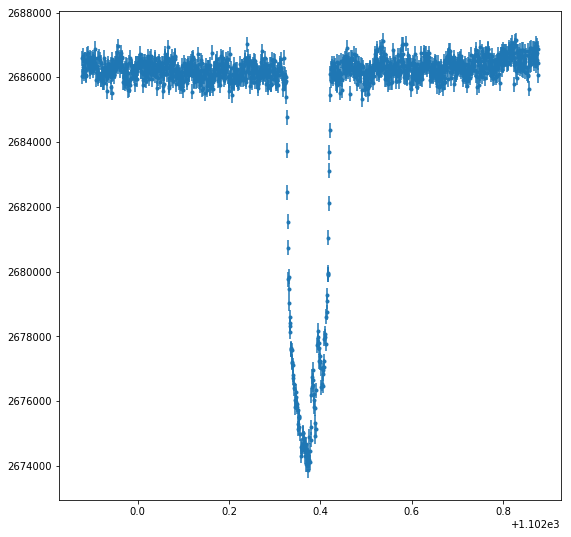

In [134]:
plt.figure(figsize=(9,9))
plt.errorbar(timeSliceK, fluxSliceK, yerr = ferrSliceK, fmt = '.')
for o in nanIndices:
    plt.errorbar(timeSliceK[o], fluxSliceK[o], yerr = ferrSliceK[o], fmt = 'o', color='orange')

** Fitting the Transit with BATMAN **

In [135]:
# From Hubert et al. 2017
kep3period = 4.88782433
kep3t0 = 2454957.812464 - keplaunch
kep3aoR = 14.64
kep3RpRs = 0.05856
kep3inc = 88.99
kep3ecc = 0.26493
kep3omeg = -162.149
kep3u1 = 0.646
kep3u2 = 0.048
timeSliceKmod = np.linspace(timeSliceK.min(), timeSliceK.max(), timeSliceK.size)

In [136]:
tparams = batman.TransitParams()
tparams.t0 = kep3t0                     #time of inferior conjunction
tparams.per = kep3period                #orbital period 
tparams.rp = kep3RpRs                   #planet radius (in units of stellar radii)
tparams.a = kep3aoR                     #semi-major axis (in units of stellar radii)
tparams.inc = kep3inc                   #orbital inclination (in degrees)
tparams.ecc = kep3ecc                   #eccentricity
tparams.w = kep3omeg                    #longitude of periastron (in degrees)
tparams.limb_dark = "quadratic"         #limb darkening model
tparams.u = [kep3u1, kep3u2]            #limb darkening coefficients [u1, u2, u3, u4]

SliceKlcModel = batman.TransitModel(tparams, timeSliceKmod, transittype='primary')

In [137]:
lckep3Model = SliceKlcModel.light_curve(tparams)

In [138]:
lckep3Model

array([ 1.,  1.,  1., ...,  1.,  1.,  1.])

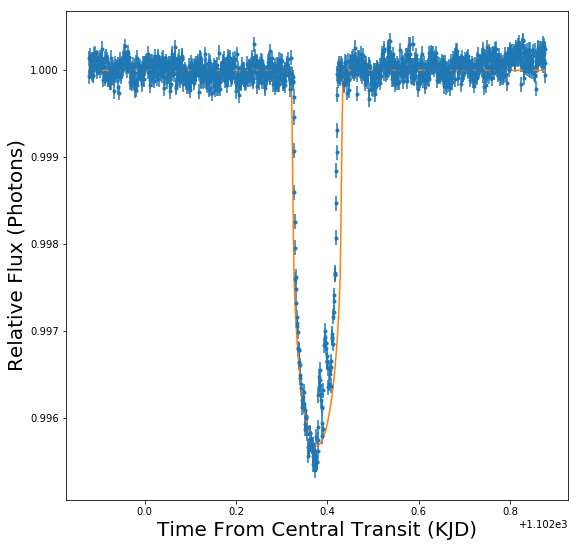

In [139]:
plt.figure(figsize = (9,9))
plt.errorbar(timeSliceK, fluxSliceK / np.median(fluxSliceK), yerr = ferrSliceK / np.median(fluxSliceK), fmt = '.')
plt.plot(timeSliceKmod, lckep3Model)
plt.xlabel("Time From Central Transit (KJD)", fontsize = 20)
plt.ylabel("Relative Flux (Photons)", fontsize = 20)

In [140]:
h11Per       = 4.88782433
h11t0        = 2454957.812464 - 2454833.0
h11Inc       = 88.99
h11ApRs      = 14.64
h11RpRs      = 0.05856
h11Ecc       = 0.26493
h11Omega     = 360-162.149
h11u1        = 0.646
h11u2        = 0.048

def batman_wrapper_mle(params, times, ldtype='quadratic', transitType='primary'):

    period, tcenter, inc, aprs, rprs, ecc, omega, u1, u2 = params

    bm_params           = batman.TransitParams() # object to store transit parameters

    bm_params.per       = period   # orbital period
    bm_params.t0        = tcenter  # time of inferior conjunction
    bm_params.inc       = inc      # inclunaition in degrees
    bm_params.a         = aprs     # semi-major axis (in units of stellar radii)
    bm_params.rp        = rprs     # planet radius (in units of stellar radii)
    bm_params.ecc       = ecc      # eccentricity
    bm_params.w         = omega    # longitude of periastron (in degrees)
    bm_params.limb_dark = ldtype   # limb darkening model # NEED TO FIX THIS
    bm_params.u         = [u1, u2] # limb darkening coefficients # NEED TO FIX THIS

    m_eclipse = batman.TransitModel(bm_params, times, transittype=transitType)# initializes model

    return m_eclipse.light_curve(bm_params)


def batman_wrapper_lmfit(period, tcenter, inc, aprs, rprs, ecc, omega, u1, u2, 
                         offset, slope, curvature,
                         times, ldtype='quadratic', transitType='primary'):

    # period, tcenter, inc, aprs, rprs, ecc, omega, u1, u2 = init_params
    
    if offset == 1.0 and slope == 0.0 and curvature == 0.0:
        OoT_curvature = 1.0 # OoT == Out of Transit
    else:
        OoT_curvature = offset + slope*(times-times.mean()) + curvature*(times-times.mean())**2
    
    bm_params           = batman.TransitParams() # object to store transit parameters

    bm_params.per       = period   # orbital period
    bm_params.t0        = tcenter  # time of inferior conjunction
    bm_params.inc       = inc      # inclunaition in degrees
    bm_params.a         = aprs     # semi-major axis (in units of stellar radii)
    bm_params.rp        = rprs     # planet radius (in units of stellar radii)
    bm_params.ecc       = ecc      # eccentricity
    bm_params.w         = omega    # longitude of periastron (in degrees)
    bm_params.limb_dark = ldtype   # limb darkening model # NEED TO FIX THIS
    bm_params.u         = [u1, u2] # limb darkening coefficients # NEED TO FIX THIS

    m_eclipse = batman.TransitModel(bm_params, times, transittype=transitType)# initializes model

    return m_eclipse.light_curve(bm_params)*OoT_curvature

def loglikehood(params, uni_prior, times, flux, fluxerr):
    model = batman_wrapper_mle(params, times)
    chisq = ((flux - model)/fluxerr)**2.
    return -0.5 * chisq.sum() # + lambda*abs(params).sum() # + lambda*np.sqrt((params**2).sum())

def logPrior(params, uni_prior, times, flux, fluxerr):
    for kp in range(len(uni_prior)):
        lower, upper = uni_prior[kp]
        if params[kp] < lower or params[kp] > upper:
            return -np.inf
    return 0.0

def logPosterior(params, uni_prior, times, flux, fluxerr):
    logPriorNow = logPrior(params, uni_prior, times, flux, fluxerr)
    logLikeLNow = loglikehood(params, uni_prior, times, flux, fluxerr)
    return logLikeLNow + logPriorNow

def neg_logprobability(params, uni_prior, times, flux, fluxerr):
    logPostNow = logPosterior(params, uni_prior, times, flux, fluxerr)
    return -2 * logPostNow

periodIn    = h11Per
tcenterIn   = h11t0
incIn       = h11Inc
aprsIn      = h11ApRs
rprsIn      = h11RpRs
eccIn       = h11Ecc
omegaIn     = h11Omega
u1In        = h11u1
u2In        = h11u2

# Initial Parameters
initParams = [periodIn, tcenterIn, incIn, aprsIn, rprsIn, eccIn, omegaIn, u1In, u2In]

# Frozen Prior
uniPrior = np.array([
            [periodIn,periodIn],
            [tcenterIn, tcenterIn],
            [incIn, incIn],
            [aprsIn, aprsIn],
            [rprsIn, rprsIn],
            [eccIn,eccIn],
            [omegaIn,omegaIn],
            [u1In,u1In],
            [u2In,u2In]
           ])

# Partial UnFrozen Prior
uniPrior = np.array([
            [periodIn, periodIn], # uniform volume for period (== 0)
            [tcenterIn - 0.1, tcenterIn + 0.1], # uniform volume for tcenter (== 0.2)
            [80., 90.], # uniform volume for inclination
            [10, 20], # uniform volume for ApRs
            [0.01, 0.1], # uniform volume for RpRs
            [eccIn,eccIn], # uniform volume for ecc
            [omegaIn,omegaIn], # uniform volume for omega
            [0.6,0.7], # uniform volume for u1
            [0.0,0.1] # uniform volume for u2
           ])

res = optmin(neg_logprobability,initParams,args=(uniPrior,timeSliceKmod,fluxSliceK,ferrSliceK), bounds=uniPrior)

print(res.x - initParams)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [141]:
from lmfit import minimize, Parameters, Model

In [142]:
initialParams = Parameters()
# period, tcenter, inc, aprs, rprs, ecc, omega, u1, u2, 
#                          times, ldtype='quadratic', transitType='primary')
initialParams.add_many(
    ('period' , kep3period, False),
    ('tcenter' , kep3t0, True, kep3t0 - 0.1, kep3t0 + 0.1),
    ('inc' , kep3inc, True, 80., 90.),
    ('aprs' , kep3aoR, True, 10, 20),
    ('rprs' , kep3RpRs, True, 0.01, 0.1),
    ('ecc' , kep3ecc, False),
    ('omega' , kep3omeg, False),
    ('u1' , kep3u1, True, 0.6, 0.7),
    ('u2' , kep3u2, True, 0.0, 0.1),
    ('offset', 1.0, True),
    ('slope', 0.0, True),
    ('curvature', 0.0, True))

In [143]:
initialParams

Parameters([('period',
             <Parameter 'period', value=4.88782433 (fixed), bounds=[-inf:inf]>),
            ('tcenter',
             <Parameter 'tcenter', 124.81246400019154, bounds=[124.71246400019155:124.91246400019153]>),
            ('inc', <Parameter 'inc', 88.99, bounds=[80.0:90.0]>),
            ('aprs', <Parameter 'aprs', 14.64, bounds=[10:20]>),
            ('rprs', <Parameter 'rprs', 0.05856, bounds=[0.01:0.1]>),
            ('ecc',
             <Parameter 'ecc', value=0.26493 (fixed), bounds=[-inf:inf]>),
            ('omega',
             <Parameter 'omega', value=-162.149 (fixed), bounds=[-inf:inf]>),
            ('u1', <Parameter 'u1', 0.646, bounds=[0.6:0.7]>),
            ('u2', <Parameter 'u2', 0.048, bounds=[0.0:0.1]>),
            ('offset', <Parameter 'offset', 1.0, bounds=[-inf:inf]>),
            ('slope', <Parameter 'slope', 0.0, bounds=[-inf:inf]>),
            ('curvature', <Parameter 'curvature', 0.0, bounds=[-inf:inf]>)])

In [144]:
lc = Model(batman_wrapper_lmfit, 
              independent_vars = ['times', 'ldtype', 'transitType'])

In [145]:
fitResult = lc.fit(fluxSliceK,
                   weights     = 1 / ferrSliceK**2.,
                   params      = initialParams,
                   method      = 'powell',
                   times       = timeSliceKmod,
                   ldtype      = 'quadratic',
                   transitType = 'primary')

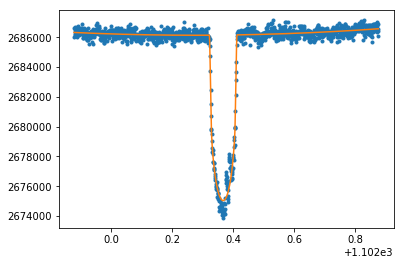

In [146]:
plt.plot(timeSliceKmod, fluxSliceK,'.')
plt.plot(timeSliceKmod, fitResult.best_fit)

In [147]:
residuals = fluxSliceK - fitResult.best_fit
chisq     = np.sum((residuals / ferrSliceK)**2.)
print(chisq / residuals.size)

2.0878439302709517


2.0878439302709517


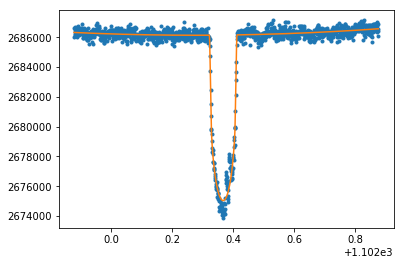

In [148]:
from lmfit import minimize, Parameters, Model

initialParams = Parameters()

initialParams.add_many(
    ('period' , kep3period, False),
    ('tcenter' , kep3t0, True, kep3t0 - 0.1, kep3t0 + 0.1),
    ('inc' , kep3inc, True, 80., 90.),
    ('aprs' , kep3aoR, True, 10, 20),
    ('rprs' , kep3RpRs, True, 0.01, 0.1),
    ('ecc' , kep3ecc, False),
    ('omega' , kep3omeg, False),
    ('u1' , kep3u1, True, 0.6, 0.7),
    ('u2' , kep3u2, True, 0.0, 0.1),
    ('offset', 1.0, True),
    ('slope', 0.0, True),
    ('curvature', 0.0, True))

initialParams

lc = Model(batman_wrapper_lmfit, 
              independent_vars = ['times', 'ldtype', 'transitType'])

fitResult = lc.fit(fluxSliceK,
                   weights     = 1 / ferrSliceK**2.,
                   params      = initialParams,
                   method      = 'powell',
                   times       = timeSliceKmod,
                   ldtype      = 'quadratic',
                   transitType = 'primary')

plt.plot(timeSliceKmod, fluxSliceK,'.')
plt.plot(timeSliceKmod, fitResult.best_fit)

residuals = fluxSliceK - fitResult.best_fit
chisq     = np.sum((residuals / ferrSliceK)**2.)
print(chisq / residuals.size)